# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** 

#### **Import Necessary Libraries**

In [ ]:
# Import libraries



In [ ]:
!pip uninstall -y scikit-learn

Found existing installation: scikit-learn 1.6.1
Uninstalling scikit-learn-1.6.1:
  Successfully uninstalled scikit-learn-1.6.1


In [ ]:
!pip install scikit-learn==1.5.2         ## this version is required for KerasRegressor

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 99.5 MB/s eta 0:00:00


In [ ]:
!pip install scikeras

In [ ]:
import sklearn
import scikeras

print("scikit-learn version:", sklearn.__version__)
print("scikeras version:", scikeras.__version__)

scikit-learn version: 1.5.2
scikeras version: 0.13.0


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from scikeras.wrappers import KerasRegressor

from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Bidirectional,SimpleRNN,GRU
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore') # ignore warnings

### **1.1 Data Aggregation**

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** 
Create the function to join DataFrames and use it to combine the four datasets.

In [ ]:
# Define a function to load data and aggregate them


def merge_data(stock1,stock2,stock3,stock4):

 amz = pd.read_csv(stock1, parse_dates=['Date'])
 goog = pd.read_csv(stock2, parse_dates=['Date'])
 ibm = pd.read_csv(stock3, parse_dates=['Date'])
 msft = pd.read_csv(stock4, parse_dates=['Date'])

 amz= amz[['Date', 'Close', 'Volume']].rename(columns={
        'Close': 'AMZ_Close', 'Volume': 'AMZ_Volume'})

 goog= goog[['Date', 'Close', 'Volume']].rename(columns={
        'Close': 'GOOG_Close', 'Volume': 'GOOG_Volume'})

 ibm= ibm[['Date', 'Close', 'Volume']].rename(columns={
        'Close': 'IBM_Close', 'Volume': 'IBM_Volume'})

 msft= msft[['Date', 'Close', 'Volume']].rename(columns={
        'Close': 'MSFT_Close', 'Volume': 'MSFT_Volume'})

 df = amz.merge(goog, on='Date').merge(ibm, on='Date').merge(msft, on='Date')

 df=df.sort_values('Date').reset_index(drop=True)

 return df



In [ ]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

stock1='/content/AMZN_stocks_data.csv'
stock2='/content/GOOGL_stocks_data.csv'
stock3='/content/IBM_stocks_data.csv'
stock4='/content/MSFT_stocks_data.csv'

df=merge_data(stock1,stock2,stock3,stock4)

In [ ]:
# View specifics of the data

df.head()

,Date,AMZ_Close,AMZ_Volume,GOOG_Close,GOOG_Volume,IBM_Close,IBM_Volume,MSFT_Close,MSFT_Volume
0,2006-01-03,47.58,7582127,217.83,13137450,82.06,11715200,26.84,79974418
1,2006-01-04,47.25,7440914,222.84,15292353,81.95,9840600,26.97,57975661
2,2006-01-05,47.65,5417258,225.85,10815661,82.50,7213500,26.99,48247610
3,2006-01-06,47.87,6154285,233.06,17759521,84.95,8197400,26.91,100969092
4,2006-01-09,47.08,8945056,233.68,12795837,83.73,6858200,26.86,55627836


In [ ]:
df.tail()

,Date,AMZ_Close,AMZ_Volume,GOOG_Close,GOOG_Volume,IBM_Close,IBM_Volume,MSFT_Close,MSFT_Volume
3014,2017-12-22,1168.36,1585054,1068.86,889446,152.50,2990583,85.51,14145841
3015,2017-12-26,1176.76,2005187,1065.85,918767,152.83,2479017,85.40,9891237
3016,2017-12-27,1182.26,1867208,1060.20,1116203,153.13,2149257,85.71,14678025
3017,2017-12-28,1186.10,1841676,1055.95,994249,154.04,2687624,85.72,10594344
3018,2017-12-29,1169.47,2688391,1053.40,1180340,153.42,3327087,85.54,18717406


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3019 entries, 0 to 3018
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         3019 non-null   datetime64[ns]
 1   AMZ_Close    3019 non-null   float64       
 2   AMZ_Volume   3019 non-null   int64         
 3   GOOG_Close   3019 non-null   float64       
 4   GOOG_Volume  3019 non-null   int64         
 5   IBM_Close    3019 non-null   float64       
 6   IBM_Volume   3019 non-null   int64         
 7   MSFT_Close   3019 non-null   float64       
 8   MSFT_Volume  3019 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(4)
memory usage: 212.4 KB


In [ ]:
df.shape


(3019, 9)

In [ ]:
df.describe()

,Date,AMZ_Close,AMZ_Volume,GOOG_Close,GOOG_Volume,IBM_Close,IBM_Volume,MSFT_Close,MSFT_Volume
count,3019,3019.000000,3.019000e+03,3019.000000,3.019000e+03,3019.000000,3.019000e+03,3019.000000,3.019000e+03
mean,2012-01-01 20:00:33.388539392,299.376231,5.931712e+06,428.044001,3.551504e+06,145.623031,5.773563e+06,36.513412,5.161762e+07
min,2006-01-03 00:00:00,26.070000,9.864350e+05,128.850000,5.211410e+05,71.740000,2.542560e+05,15.150000,7.425603e+06
25%,2009-01-01 00:00:00,81.090000,3.137037e+06,247.605000,1.760854e+06,116.520000,3.622178e+06,26.835000,3.136557e+07
50%,2011-12-30 00:00:00,205.440000,4.724100e+06,310.080000,2.517630e+06,149.330000,4.926500e+06,30.000000,4.617529e+07
75%,2015-01-01 00:00:00,375.140000,7.135246e+06,570.770000,4.242182e+06,178.690000,6.966642e+06,44.400000,6.322291e+07
max,2017-12-29 00:00:00,1195.830000,1.044046e+08,1085.090000,4.118289e+07,215.800000,3.077428e+07,86.850000,5.910786e+08
std,NaN,279.980161,5.122034e+06,236.343238,3.038599e+06,37.534272,3.193327e+06,14.694656,3.114958e+07


In [ ]:
df=df.set_index('Date')

In [ ]:
df.head()

,AMZ_Close,AMZ_Volume,GOOG_Close,GOOG_Volume,IBM_Close,IBM_Volume,MSFT_Close,MSFT_Volume
Date,,,,,,,,
2006-01-03,47.58,7582127,217.83,13137450,82.06,11715200,26.84,79974418
2006-01-04,47.25,7440914,222.84,15292353,81.95,9840600,26.97,57975661
2006-01-05,47.65,5417258,225.85,10815661,82.50,7213500,26.99,48247610
2006-01-06,47.87,6154285,233.06,17759521,84.95,8197400,26.91,100969092
2006-01-09,47.08,8945056,233.68,12795837,83.73,6858200,26.86,55627836


#### **1.1.2** 
Identify and handle any missing values.

In [ ]:
# Handle Missing Values

df.isnull().sum()

,0
AMZ_Close,0
AMZ_Volume,0
GOOG_Close,0
GOOG_Volume,0
IBM_Close,0
IBM_Volume,0
MSFT_Close,0
MSFT_Volume,0


In [ ]:
## there are no missing values

### **1.2 Analysis and Visualisation** 

#### **1.2.1** 
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

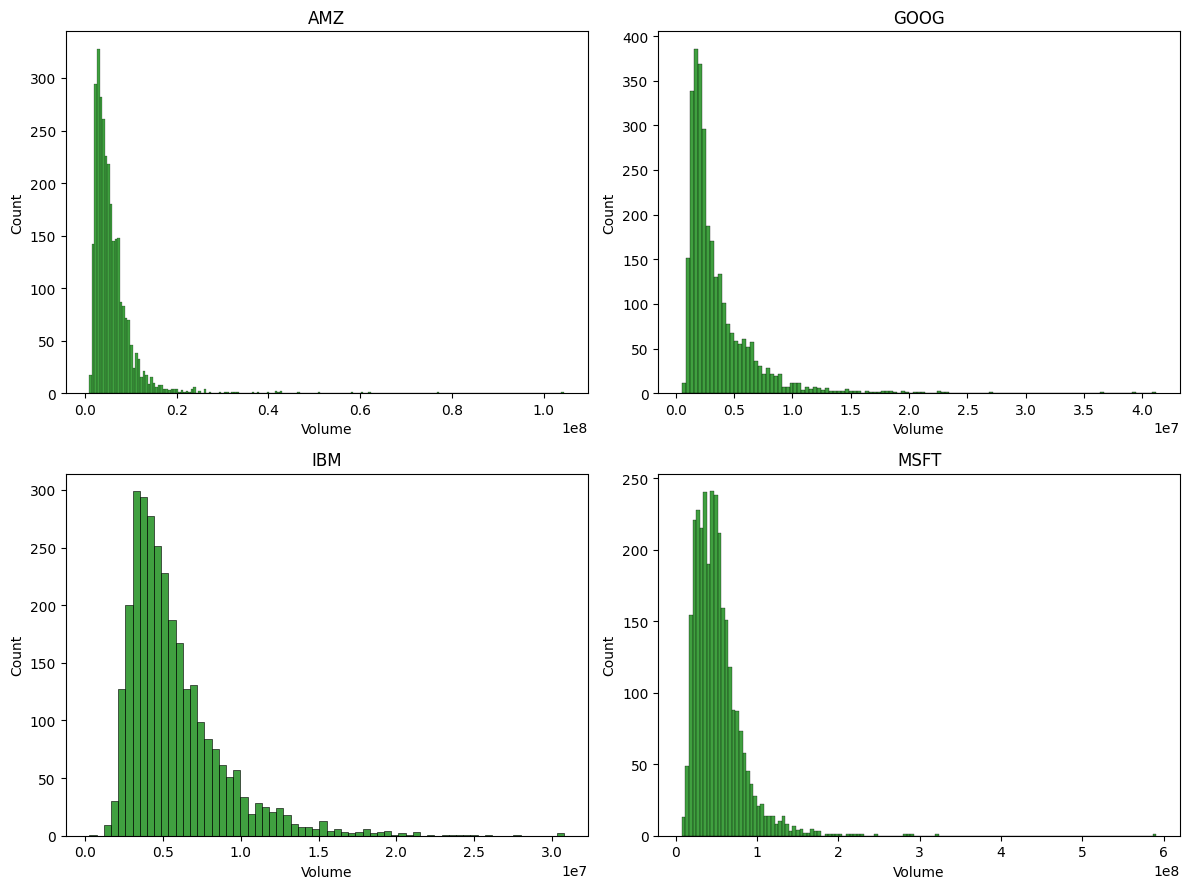

In [ ]:
## histogram for volume
plt.figure(figsize=(12, 9))
stock_list=['AMZ','GOOG','IBM','MSFT']
for i, company in enumerate(stock_list, 1):
    plt.subplot(2, 2, i)
    #df[f'{company}_Volume'].hist(bins=50)
    sns.histplot(df[f'{company}_Volume'],color='green')
    plt.xlabel('Volume')
    #plt.ylabel('Counts')
    plt.title(f'{company}')

plt.tight_layout()

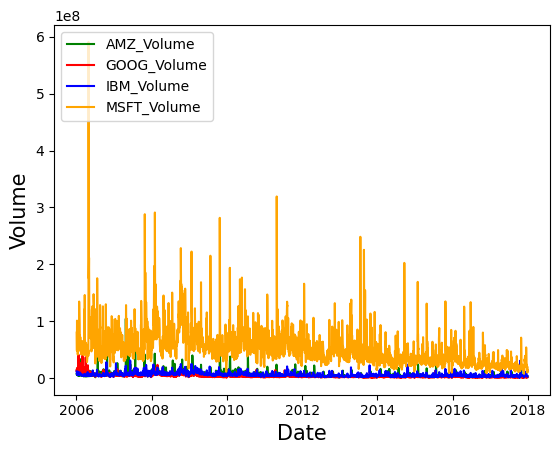

In [ ]:
# Stock volume variation over time

plt.plot(df['AMZ_Volume'],label='AMZ_Volume',color='green')
plt.plot(df['GOOG_Volume'],label='GOOG_Volume',color='red')
plt.plot(df['IBM_Volume'],label='IBM_Volume',color='blue')
plt.plot(df['MSFT_Volume'],label='MSFT_Volume',color='orange')
plt.xlabel('Date',size=15)
plt.ylabel('Volume',size=15)
plt.legend(loc = "upper left")
plt.show()

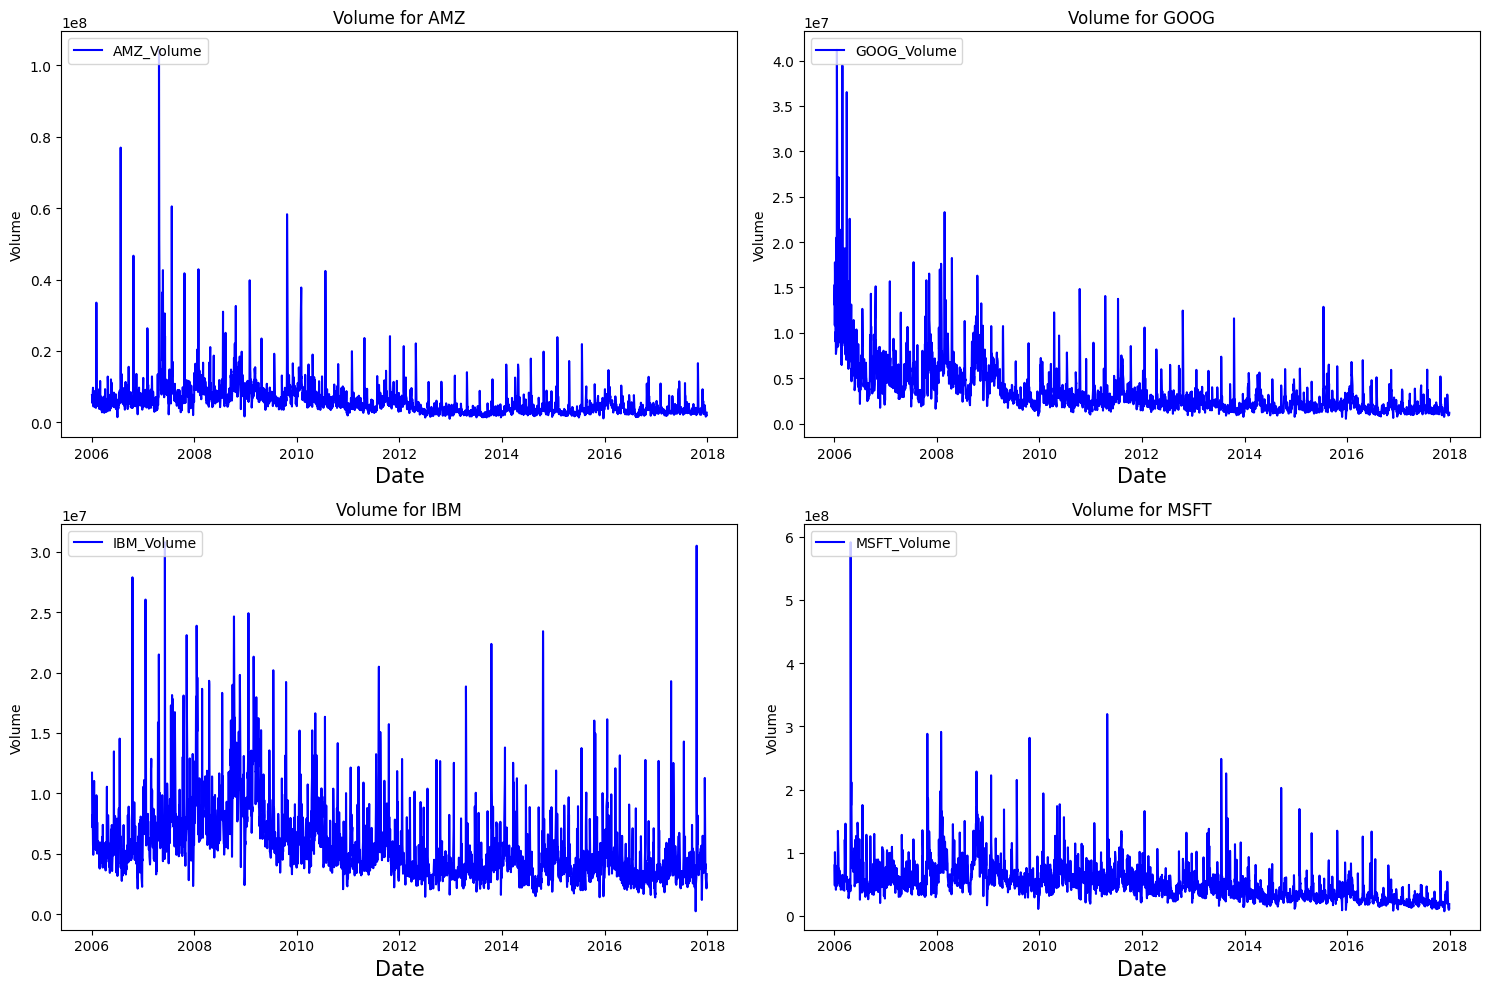

In [ ]:
plt.figure(figsize=(15, 10))

stock_list=['AMZ','GOOG','IBM','MSFT']
for i, company in enumerate(stock_list,start=1):
    plt.subplot(2, 2, i)
    #df[f'{company}_Volume'].plot()
    plt.plot(df[f'{company}_Volume'],label=f'{company}_Volume',color='blue')
    plt.xlabel('Date',size=15)
    plt.ylabel('Volume')
    plt.legend(loc = "upper left")
    plt.title(f"Volume for {company}")

plt.tight_layout()

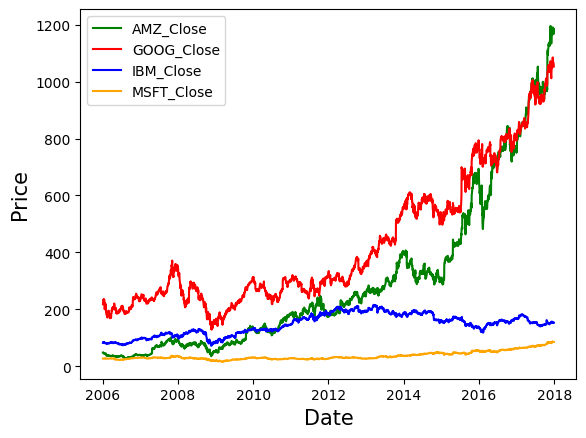

In [ ]:
## closing price

plt.plot(df['AMZ_Close'],label='AMZ_Close',color='green')
plt.plot(df['GOOG_Close'],label='GOOG_Close',color='red')
plt.plot(df['IBM_Close'],label='IBM_Close',color='blue')
plt.plot(df['MSFT_Close'],label='MSFT_Close',color='orange')
plt.xlabel('Date',size=15)
plt.ylabel('Price',size=15)
plt.legend(loc = "upper left")
plt.show()

#### **1.2.2** 
Analyse correlations between features.

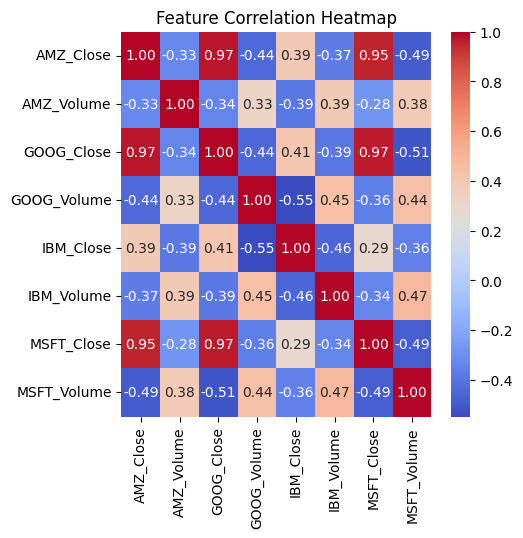

In [ ]:
# Analyse correlations


plt.figure(figsize=(5, 5))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
## AMZ close price is highly correlated with GOOG close price and MSFT close price
## GOOG close price is highly correlated with AMZ close price and MSFT close price

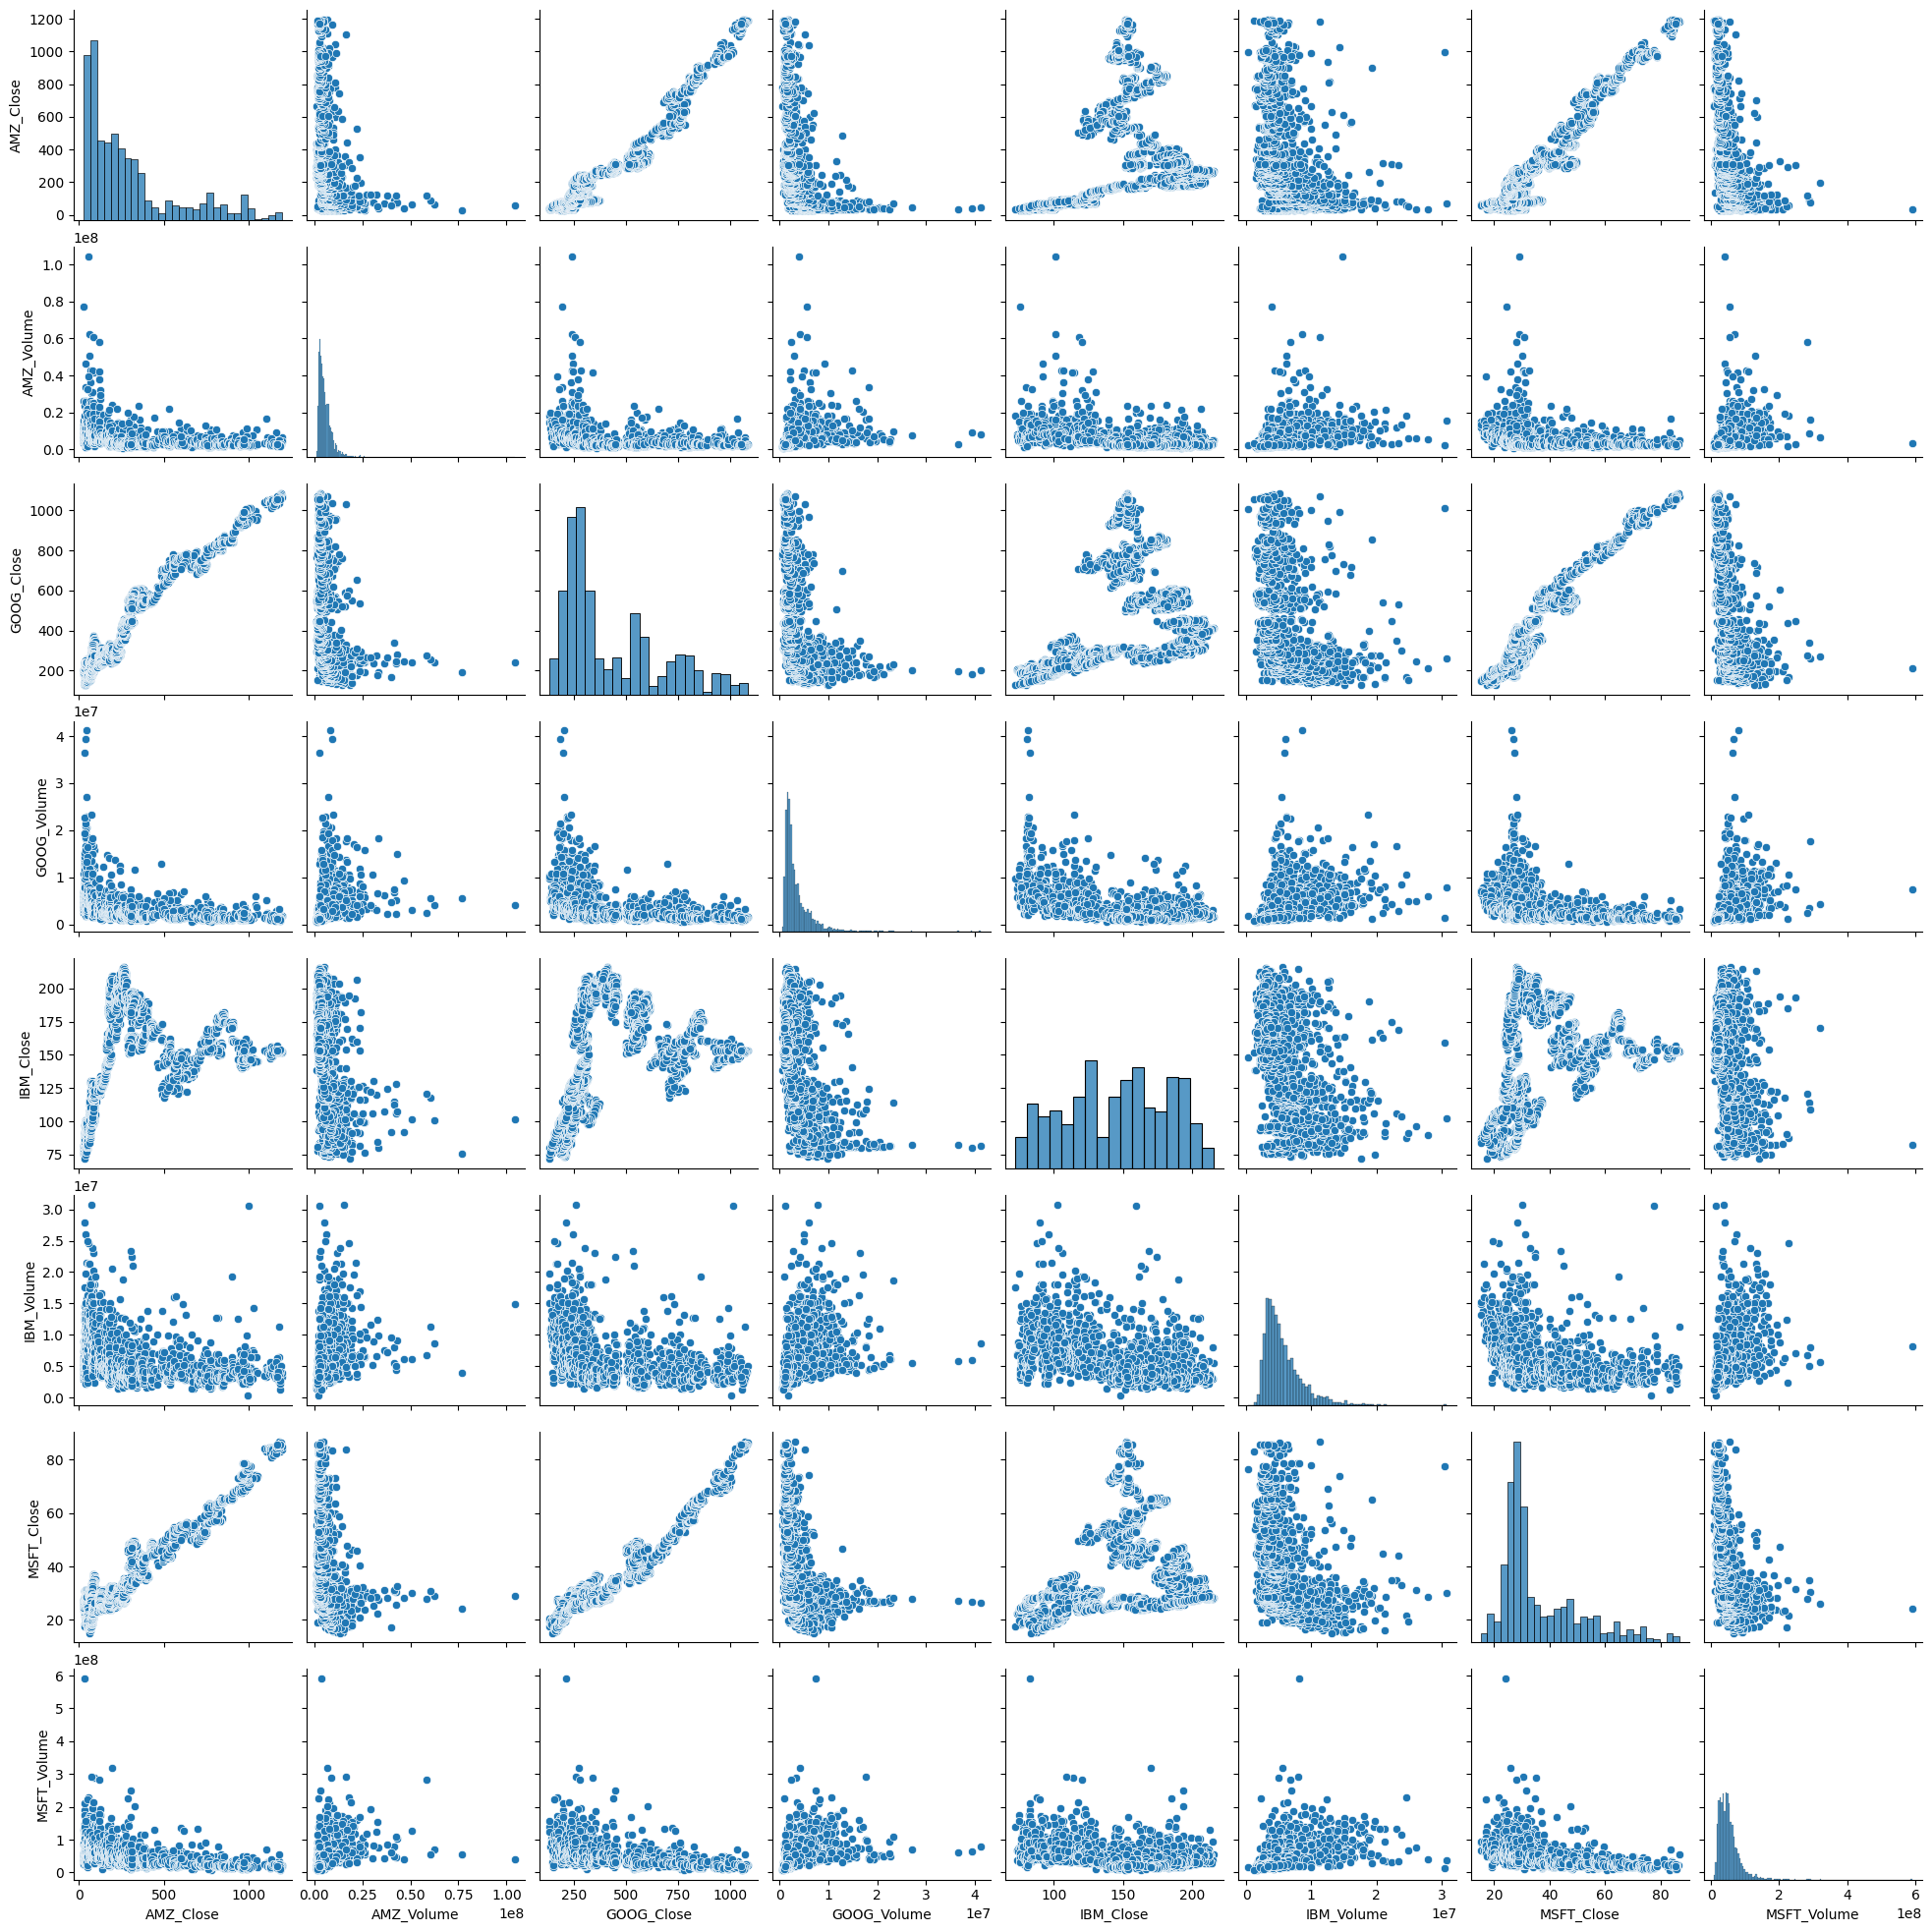

In [ ]:
sns.pairplot(df)
plt.show()

### **1.3 Data Processing** 

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** 
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [ ]:
# Define a function that divides the data into windows and generates target variable values for each window



In [ ]:
len(df)

3019

In [ ]:
train_size = int(len(df) * 0.8)       ## taking 80% data for training
train_data = df[:train_size]
test_data = df[train_size:]

In [ ]:
train_data.shape


(2415, 8)

In [ ]:
test_data.shape

(604, 8)

In [ ]:
train_data.head()

,AMZ_Close,AMZ_Volume,GOOG_Close,GOOG_Volume,IBM_Close,IBM_Volume,MSFT_Close,MSFT_Volume
Date,,,,,,,,
2006-01-03,47.58,7582127,217.83,13137450,82.06,11715200,26.84,79974418
2006-01-04,47.25,7440914,222.84,15292353,81.95,9840600,26.97,57975661
2006-01-05,47.65,5417258,225.85,10815661,82.50,7213500,26.99,48247610
2006-01-06,47.87,6154285,233.06,17759521,84.95,8197400,26.91,100969092
2006-01-09,47.08,8945056,233.68,12795837,83.73,6858200,26.86,55627836


In [ ]:
test_data.head()

,AMZ_Close,AMZ_Volume,GOOG_Close,GOOG_Volume,IBM_Close,IBM_Volume,MSFT_Close,MSFT_Volume
Date,,,,,,,,
2015-08-10,524.00,2615926,663.14,1722915,156.75,4613391,47.33,23079870
2015-08-11,527.46,2676600,690.30,5494011,155.51,3167111,46.41,29237402
2015-08-12,525.91,4014684,691.47,2932328,156.16,3624852,46.74,30198532
2015-08-13,529.66,2895238,686.51,1817748,155.07,2533378,46.73,22627241
2015-08-14,531.52,1994799,689.37,1379855,155.75,3226434,47.00,21473402


#### **1.3.2** 
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.



In [ ]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

scaler = MinMaxScaler(feature_range=(0, 1))


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** 
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [ ]:
# Define a function to create input and output data points from the master DataFrame



In [ ]:
features = ['AMZ_Close', 'AMZ_Volume', 'GOOG_Close', 'GOOG_Volume',
            'IBM_Close', 'IBM_Volume', 'MSFT_Close', 'MSFT_Volume']
target = 'AMZ_Close'

In [ ]:
train_scaled = scaler.fit_transform(train_data)                    ##fit_transform on train data

In [ ]:
test_scaled = scaler.transform(test_data)                          ## transform on test data to avoid data leakage


In [ ]:
train_scaled

array([[0.04209888, 0.06377693, 0.15589467, ..., 0.3500265 , 0.33923389,
        0.11877789],
       [0.04145301, 0.06241147, 0.16467228, ..., 0.28609684, 0.34300638,
        0.08084866],
       [0.04223588, 0.04284376, 0.16994586, ..., 0.1965046 , 0.34358677,
        0.064076  ],
       ...,
       [1.        , 0.0184002 , 0.95386933, ..., 0.06893426, 0.94109112,
        0.0273723 ],
       [0.98522331, 0.02740349, 0.94836799, ..., 0.05297476, 0.91323273,
        0.02807635],
       [0.97183622, 0.02884194, 0.93827636, ..., 0.07991965, 0.91671503,
        0.01392973]])

In [ ]:
train_scaled.shape

(2415, 8)

In [ ]:
target_scaler = MinMaxScaler(feature_range=(0, 1))

In [ ]:
target_scaled = target_scaler.fit_transform(train_data['AMZ_Close'].values.reshape(-1, 1))

We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** 
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

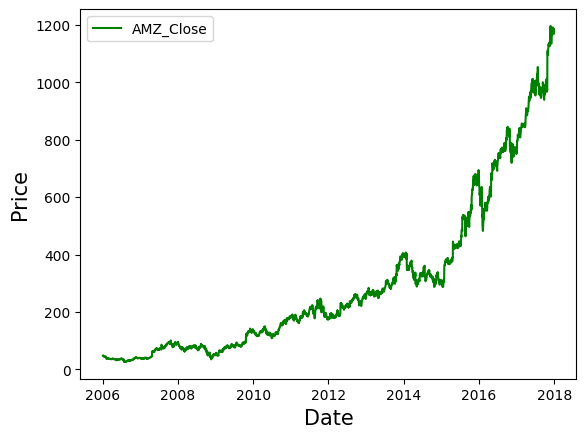

In [ ]:
# Checking for patterns in different sequence lengths

plt.plot(df['AMZ_Close'],label='AMZ_Close',color='green')
plt.xlabel('Date',size=15)
plt.ylabel('Price',size=15)
plt.legend(loc = "upper left")
plt.show()

## window size of 30 days seems to be appropriate

#### **1.3.5** 
Call the functions to create testing and training instances of predictor and target features.

In [ ]:
# Create data instances from the master data frame using decided window size and window stride


window_size = 30
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i - window_size:i])  # previous 'window_size' days
        y.append(data[i][0])  # next day's target value (predicting closing price)
    return np.array(X), np.array(y)

# Create sequences for train and test data
X_train, y_train = create_sequences(train_scaled, window_size)
X_test, y_test = create_sequences(test_scaled, window_size)


In [ ]:
# Check the number of data points generated
X_train.shape

(2385, 30, 8)

In [ ]:
y_train.shape

(2385,)

In [ ]:
X_test.shape

(574, 30, 8)

In [ ]:
y_test.shape

(574,)

**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [ ]:
# Check if the datasets are compatible inputs to neural networks

# reshape input to be [samples, time steps, features] which is required for LSTM



In [ ]:
X_train.shape

(2385, 30, 8)

In [ ]:
y_train.shape

(2385,)

In [ ]:
X_test.shape

(574, 30, 8)

In [ ]:
y_test.shape

(574,)

In [ ]:
## X_train and X_test are already 3D of shape (samples, time steps, features) therefore are compatible, no need to reshape

## **2 RNN Models** 

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** 

#### **2.1.1** 
Create a function that builds a simple RNN model based on the layer configuration provided.

In [ ]:
# Create a function that creates a simple RNN model according to the model configuration arguments



In [ ]:
def create_rnn_model(units=50, dropout_rate=0.1, optimizer='adam'):
    model = Sequential()
    model.add(SimpleRNN(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(units=units))

    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

#### **2.1.2** 
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration of simple RNN


regressor = KerasRegressor(model=create_rnn_model, verbose=0)


param_grid = {
    'model__units': [50, 64],
    'model__dropout_rate': [0.1, 0.2],
    'model__optimizer': ['adam'],

    'epochs': [30, 50]
}

# Use TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)

grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1
)

# Fit grid search to the data
grid_search.fit(X_train, y_train)


print("Best CV Score (negative MSE):", grid_search.best_score_)


Best CV Score (negative MSE): -0.00233744727585682


In [ ]:
# Find the best configuration based on evaluation metrics

print("Best Parameters:", grid_search.best_params_)

Best Parameters: {'epochs': 50, 'model__dropout_rate': 0.2, 'model__optimizer': 'adam', 'model__units': 64}


#### **2.1.3** 
Run for optimal Simple RNN Model and show final results.

In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

best_model_rnn = grid_search.best_estimator_

test_predict=best_model_rnn.predict(X_test)


In [ ]:
test_predict.shape

(574,)

In [ ]:
X_test.shape

(574, 30, 8)

In [ ]:
y_test.shape

(574,)

In [ ]:
test_predict_rescaled=target_scaler.inverse_transform(test_predict.reshape(-1, 1))

In [ ]:
y_test_actual=target_scaler.inverse_transform(y_test.reshape(-1, 1))

Plotting the actual vs predicted values

In [ ]:
# Predict on the test data and plot


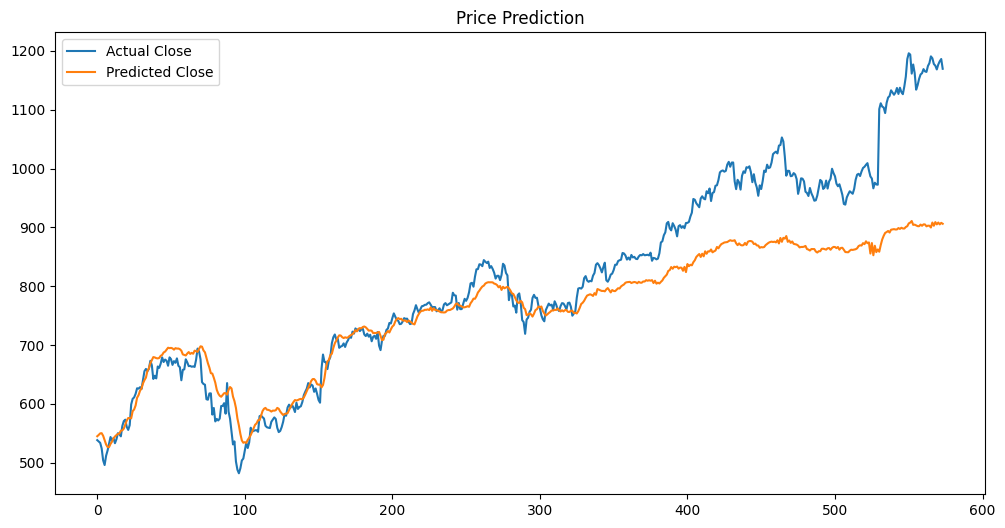

In [ ]:

plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Close')
plt.plot(test_predict_rescaled, label='Predicted Close')
plt.title('Price Prediction')
plt.legend()
plt.show()

It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [ ]:
# Compute the performance of the model on the testing data set

##rmse
math.sqrt(mean_squared_error(y_test_actual,test_predict_rescaled))

92.08670490192235

In [ ]:
best_model_rnn.model_.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 30, 64)         │         4,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,981 (152.27 KB)

 Trainable params: 12,993 (50.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 25,988 (101.52 KB)

### **2.2 Advanced RNN Models** 

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** 
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [ ]:
# # Define a function to create a model and specify default values for hyperparameters




In [ ]:
def create_lstm_model(units=50, dropout_rate=0.1, optimizer='adam'):
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units))

    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model




#### **2.2.2** 
Perform hyperparameter tuning to find the optimal network configuration.

In [ ]:
# Find an optimal configuration


regressor = KerasRegressor(model=create_lstm_model, verbose=0)


param_grid = {
    'model__units': [50, 64],
    'model__dropout_rate': [0.1, 0.2],
    'model__optimizer': ['adam'],

    'epochs': [30, 50]
}

# Use TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)


grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1
)

# Fit grid search to the data
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (negative MSE):", grid_search.best_score_)

Best Parameters: {'epochs': 30, 'model__dropout_rate': 0.1, 'model__optimizer': 'adam', 'model__units': 64}
Best CV Score (negative MSE): -0.0004172589553806218


#### **2.2.3** 
Run for optimal RNN Model and show final results.

In [ ]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model

best_model_lstm = grid_search.best_estimator_

test_predict=best_model_lstm.predict(X_test)

In [ ]:
test_predict.shape

(574,)

In [ ]:
X_test.shape

(574, 30, 8)

In [ ]:
y_test.shape

(574,)

In [ ]:
test_predict_rescaled=target_scaler.inverse_transform(test_predict.reshape(-1, 1))

In [ ]:
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
# Compute the performance of the model on the testing data set

##rmse
math.sqrt(mean_squared_error(y_test_actual,test_predict_rescaled))

21.417745641083552

Plotting the actual vs predicted values

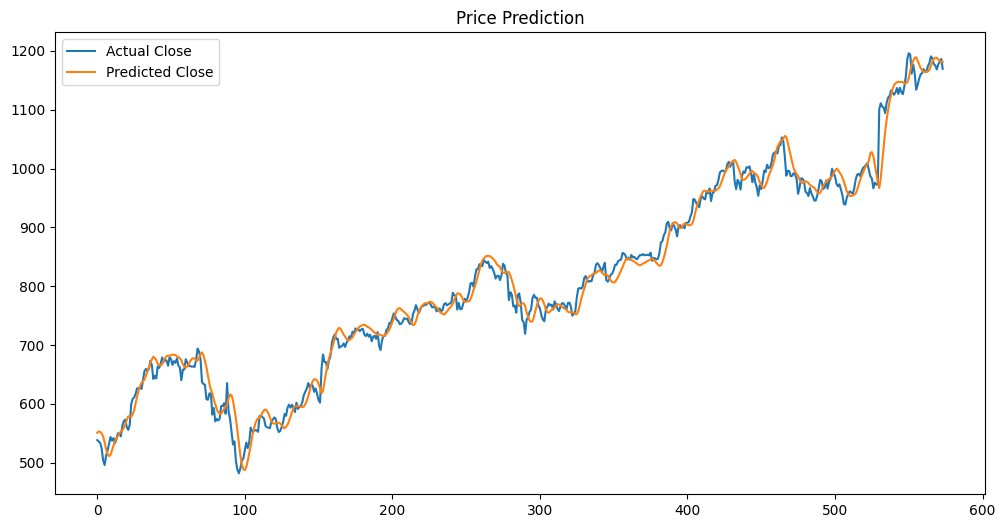

In [ ]:
# Predict on the test data

plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Close')
plt.plot(test_predict_rescaled, label='Predicted Close')
plt.title('Price Prediction')
plt.legend()
plt.show()

In [ ]:
best_model_lstm.model_.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 30, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,333 (606.77 KB)

 Trainable params: 51,777 (202.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 103,556 (404.52 KB)

In [ ]:
def create_gru_model(units=50, dropout_rate=0.1, optimizer='adam'):
    model = Sequential()
    model.add(GRU(units=units, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(GRU(units=units))

    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

In [ ]:
regressor = KerasRegressor(model=create_gru_model, verbose=0)


param_grid = {
    'model__units': [50, 64],
    'model__dropout_rate': [0.1, 0.2],
    'model__optimizer': ['adam'],

    'epochs': [30, 50]
}

# Use TimeSeriesSplit for time series cross-validation
tscv = TimeSeriesSplit(n_splits=3)


grid_search = GridSearchCV(
    estimator=regressor,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1
)

# Fit grid search to the data
grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)
print("Best CV Score (negative MSE):", grid_search.best_score_)

Best Parameters: {'epochs': 50, 'model__dropout_rate': 0.2, 'model__optimizer': 'adam', 'model__units': 64}
Best CV Score (negative MSE): -0.00022328964805805565


In [ ]:

best_model_gru = grid_search.best_estimator_

test_predict=best_model_gru.predict(X_test)

In [ ]:
test_predict_rescaled=target_scaler.inverse_transform(test_predict.reshape(-1, 1))

In [ ]:
y_test_actual = target_scaler.inverse_transform(y_test.reshape(-1, 1))

In [ ]:
##rmse
math.sqrt(mean_squared_error(y_test_actual,test_predict_rescaled))

29.969533549710906

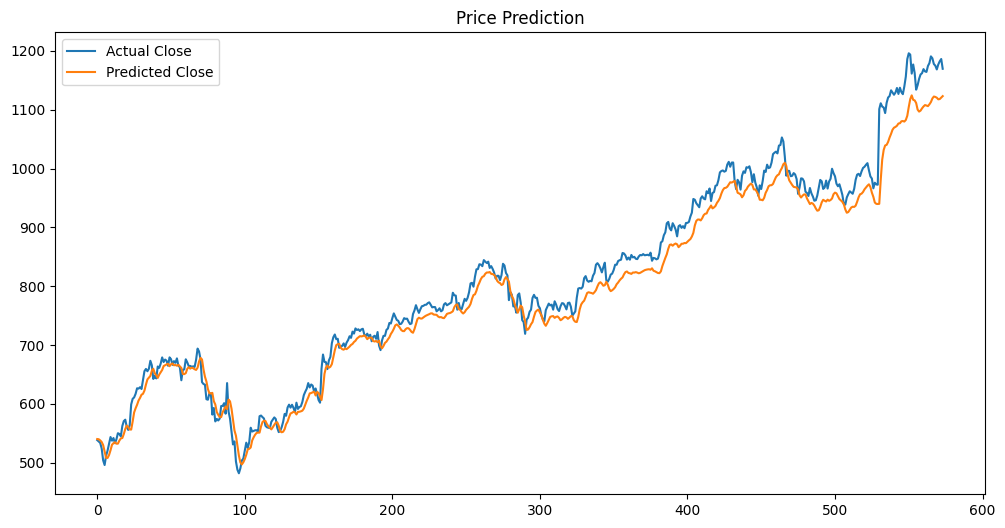

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Close')
plt.plot(test_predict_rescaled, label='Predicted Close')
plt.title('Price Prediction')
plt.legend()
plt.show()

In [ ]:
best_model_gru.model_.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 64)         │        14,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 64)             │        24,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 117,701 (459.77 KB)

 Trainable params: 39,233 (153.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 78,468 (306.52 KB)

## **3 Conclusion** 

We used stock market data to train an RNN model. The model learns from past price patterns and trends, enabling it to predict future stock prices. Closing price and Volume of AMZ, GOOG, IBM, MSFT were used to predict AMZ close price.

We preprocessed the data, splitting it into training and testing sets.
We used MinMaxScaler to normalize the data, ensuring all features contribute equally to the model and preventing any single feature from dominating due to its scale. We applied only transform to test data to avoid data leakage. We trained the model on the training dataset, adjusting various hyperparameters.We employed techniques like dropout to prevent overfitting.

We first built a simple RNN model and tuned it for various hyperparamter values. The optimal model was then tested on test data.
 RMSE for simple RNN model was 92.086

Then we built an advanced RNN model using stacked LSTM layers.
RMSE for LSTM model was 21.4177

As expected, there was a reduction in RMSE values. No. of parameters were also more in LSTM.

